# Get ready

First, download, import, prep packages and such. 

Then, check the file location and import the .csv files. Remove any with empty text fields. 

Save a data frame with all the texts and another with only those texts that mention the keywords of interest. 

In [1]:
%%capture

# installing necessary pdf conversion packages via pip
# the '%%capture' at the top of this cell suppresses the output (which is normally quite long and annoying looking). 
# You can remove or comment it out if you prefer to see the output. 
!pip install nltk
!pip install autocorrect        
!pip install pyspellchecker 
!pip install spacy -q
!python -m spacy download en_core_web_lg -q


In [27]:
import os                         # os is a module for navigating your machine (e.g., file directories).

import nltk                       # nltk stands for natural language tool kit and is useful for text-mining. 
from nltk import word_tokenize    # and some of its key functions
from nltk import sent_tokenize  
tokenizer = nltk.tokenize.punkt.PunktSentenceTokenizer()
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
from nltk.corpus import wordnet                    # Finally, things we need for lemmatising!
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer() 
from nltk.stem.porter import PorterStemmer
porter = PorterStemmer()
nltk.download('averaged_perceptron_tagger')        # Like a POS-tagger...
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('webtext')
from nltk.corpus import webtext

import pandas as pd
pd.set_option('display.max_colwidth', 200)
import numpy as np
import statistics
import datetime
date = datetime.date.today()

from autocorrect import Speller   # things we need for spell checking
check = Speller(lang='en')
import codecs
import csv                        # csv is for importing and working with csv files

from collections import Counter

import statistics
import re                         # things we need for RegEx corrections
import matplotlib.pyplot as plt
import string 
import spacy 
from spacy.matcher import Matcher 
from spacy.tokens import Span 
from spacy import displacy 
nlp = spacy.load('en_core_web_lg')
nlp.max_length = 1500000 #or any large value, as long as you don't run out of RAM

import math 

English_punctuation = "-!\"#$%&()'*-–+,./:;<=>?@[\]^_`{|}~''“”"      # Things for removing punctuation, stopwords and empty strings
table_punctuation = str.maketrans('','', English_punctuation)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\mzyssjkc\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mzyssjkc\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\mzyssjkc\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mzyssjkc\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\mzyssjkc\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\mzyssjkc\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already u

In [3]:
print(os.listdir("..\\results")  )

files = []
def import_results(input):
    for f in os.listdir(input):
        f = pd.read_csv(input + '\\'+ f)
        files.append(f)
    output = pd.concat(files)
    return output

['ESHG2001abstractICHG.csv', 'ESHG2002Abstracts.csv', 'ESHG2016Abstracts.csv']


In [4]:
all_results = import_results("..\\results")
len(all_results)

5767

In [60]:
no_null_texts = all_results[~all_results['Text'].isnull()]
len(no_null_texts)

5604

In [61]:
matched_texts = no_null_texts[no_null_texts['Text'].str.contains('autis|Autis|ASD|Asperger|asperger')]
len(matched_texts)

147

# Count word frequencies 
## Bag of words

Proceed through the 'bag of words' steps for the data frames with all texts and then again for the data frame with only the texts that mention the keywords of interest. This approach finds word frequencies for all years together. 

In [53]:
def bag_of_words_analysis(input, how_many):
    holding_string = ""
    for text in input['Text']:
        holding_string += text
    holding_string = word_tokenize(holding_string)
    holding_string = [word.lower() for word in holding_string]
    holding_string = [w.translate(table_punctuation) for w in holding_string]
    holding_string = (list(filter(lambda x: x, holding_string)))
    holding_string = [token for token in holding_string if not token.isdigit()]
    holding_string = [token for token in holding_string if token not in stop_words]
    holding_string = [porter.stem(token) for token in holding_string]
    list_for_count = []
    for token in holding_string:
        list_for_count.append(token)
    counts = Counter(list_for_count)
    return counts.most_common(how_many)

In [62]:
bag_of_words_analysis(no_null_texts, 13)

[('gene', 10592),
 ('mutat', 8798),
 ('patient', 8155),
 ('genet', 5760),
 ('studi', 4831),
 ('use', 4583),
 ('chromosom', 4274),
 ('case', 4193),
 ('famili', 4162),
 ('analysi', 3989),
 ('result', 3921),
 ('diseas', 3458),
 ('sequenc', 3309),
 ('clinic', 3210),
 ('cell', 3141)]

In [63]:
bag_of_words_analysis(matched_texts, 13)

[('patient', 286),
 ('gene', 253),
 ('syndrom', 187),
 ('mutat', 180),
 ('autism', 165),
 ('asd', 155),
 ('clinic', 149),
 ('disord', 146),
 ('genet', 145),
 ('studi', 142),
 ('chromosom', 138),
 ('delet', 134),
 ('case', 123),
 ('associ', 113),
 ('use', 109)]

## Word Frequency by year

In [204]:

def track_word_over_time(input, target_word):
    years = input['Year'].drop_duplicates()
    target_counts = []
    for year in years:
        year_bag = ""
        for text in no_null_texts['Text'][no_null_texts['Year']==year]:
            year_bag += text
        year_bag = word_tokenize(year_bag)
        year_bag = [word.lower() for word in year_bag]
        year_bag = [w.translate(table_punctuation) for w in year_bag]
        year_bag = (list(filter(lambda x: x, year_bag)))
        year_bag = [token for token in year_bag if not token.isdigit()]
        year_bag = [token for token in year_bag if token not in stop_words]
        year_bag = [porter.stem(token) for token in year_bag]
        list_for_count = []
        for token in year_bag:
            list_for_count.append(token)
        counts = Counter(list_for_count)
        target_counts.append(counts[target_word])
        
    target_word_by_year = pd.DataFrame(list(zip(years, target_counts)), columns = ['Year', str(target_word)])
    return target_word_by_year


In [224]:
target_word_list = ['gene', 'cancer', 'risk']

for word in target_word_list:
    word  = track_word_over_time(no_null_texts, word)
    return



<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>


AttributeError: 'str' object has no attribute 'set_index'

<AxesSubplot: xlabel='Year'>

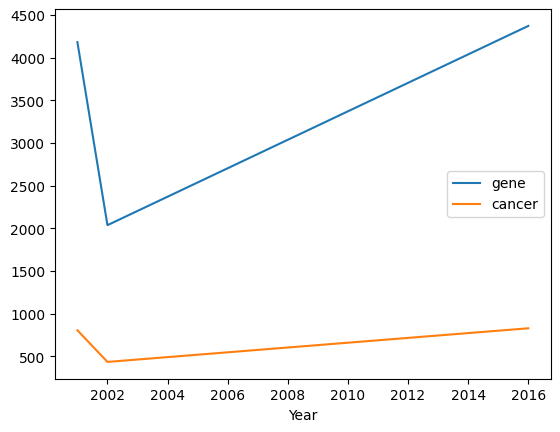

In [213]:
to_plot = [target_word.set_index('Year') for target_word in target_word_list]
to_plot[0].join(to_proh[1:])


#combine = gene.set_index('Year').join(cancer.set_index('Year'), how='left')
to_plot.plot()


TypeError: plot got an unexpected keyword argument 'x'

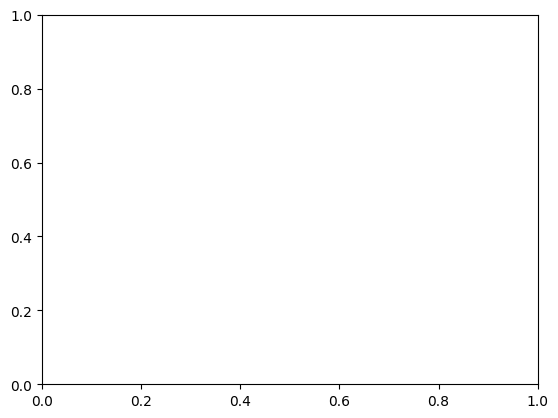

In [192]:
gene = track_word_over_time(no_null_texts, 'gene')
plt.plot(x=gene['Year'], y=gene['Count'], linestyle = 'dotted')
plt.show()

NameError: name 'target_word_by_year' is not defined

# Sent tokenisation

In [ ]:
isolated_sent = matched_texts.explode('tokenized_sents')
len(isolated_sent)

In [ ]:
matched_sents = isolated_sent[~isolated_sent['tokenized_sents'].str.contains('autis|Autis|ASD|Asperger|asperger')]
len(matched_sents)

In [ ]:
matched_sents

In [ ]:
search for word count - mutation - show frequency decreasing over time, increase in variant? gene change? 

disease also to decrease and condition or disorder to increase

In [ ]:
#for saving output
os.makedirs('folder/subfolder', exist_ok=True)  
df.to_csv('folder/subfolder/out.csv') 